In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt
torch.set_printoptions(2)

In [35]:
def multibox_prior(data, sizes, ratios):
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    #
    # 偏移量
    # 使得锚框中心点 移动到 像素中心
    # 思考：像素不是最小单位吗  怎么还能移0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height
    steps_w = 1.0 / in_width

    #
    # 生成锚框所有中心点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_W = (torch.arange(in_width, device=device) + offset_w) * steps_w

    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    #
    # tensor([0.75, 0.50, 0.25]), tensor([1.00, 2.00, 0.50]))
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:]))) \
                    * in_height / in_width
    
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                    sizes[0] / torch.sqrt(ratio_tensor[1:])))

    anchor_manipulations = torch.stack((-w , -h ,w , h)).T.repeat(in_height*in_width,1) / 2

    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                            dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [36]:
img = plt.imread('../data/genshin.png')
h, w = img.shape[:2]
h, w

(1080, 1920)

In [37]:
X = torch.rand(size=(1,3,h,w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1,2,0.5])
Y.shape

torch.Size([1, 10368000, 4])

In [41]:
boxes = Y.reshape(h,w,5,4)
boxes.shape
boxes[250,250,0,:]

torch.Size([1080, 1920, 5, 4])

tensor([-0.08, -0.14,  0.34,  0.61])

In [42]:
# 显示以图像中一个像素为中心的所有锚框

In [53]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    print("bboxes",bboxes.shape)
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
                      ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

In [54]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
bbox_scale

tensor([1920, 1080, 1920, 1080])

bboxes torch.Size([5, 4])


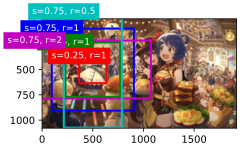

In [57]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[500, 500, :, :] * bbox_scale, [
    's=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2', 's=0.75, r=0.5'
])

交并比 IoU

In [ ]:
# 一个box的 shape 是 ..., 4
def box_iou(boxes1, boxes2):
    #
    # 算面积 长乘宽
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) * (boxes[:,3] - boxes[:,1])) 
    areas1 = box_area(boxes)
    areas2 = box_area(boxes)
#这两行代码中的 None 是 PyTorch 中用于扩展维度（unsqueeze）的一个写法，
#本质上是 unsqueeze(dim=1) 的语法糖，
#目的是让两个张量形状对齐以便进行广播运算（broadcasting）。
"""
boxes1[:, None, :2]
- boxes1[:, :2] 取的是每个框的左上角 (x1, y1)，形状是 (N, 2)
- boxes1[:, None, :2] 会在第1维插入一个维度，变成 (N, 1, 2)

boxes2[:, :2]
- 形状是 (M, 2)

通过 PyTorch 的广播机制：
- (N, 1, 2) 和 (M, 2) 自动广播为 (N, M, 2)

"""
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])

    inters = (inter_lowerrights - inter_upperlefts).clmap(min=0)

    inter_areas = inters[:,:,0] * inters[:,:,1]
    union_areas = areas[:,None] + areas2 - inter_areas
    return inter_areas / union_areas

In [20]:
#
# Debug
X = torch.rand(size=(1,3,h,w))
sizes=[0.75, 0.5, 0.25]
ratios=[1,2,0.5]

X.shape[-2:]
in_height, in_width = X.shape[-2:]

X.device, len(sizes), len(ratios)
device, num_sizes, num_ratios = X.device, len(sizes), len(ratios)

boxes_per_pixel = (num_sizes + num_ratios - 1)
size_tensor = torch.tensor(sizes, device=device)
ratio_tensor = torch.tensor(ratios, device=device)

boxes_per_pixel, size_tensor, ratio_tensor

torch.Size([1080, 1920])

(device(type='cpu'), 3, 3)

(5, tensor([0.75, 0.50, 0.25]), tensor([1.00, 2.00, 0.50]))

In [24]:
#
# 偏移量
# 使得锚框中心点 移动到 像素中心
# 思考：像素不是最小单位吗  怎么还能移0.5
offset_h, offset_w = 0.5, 0.5
steps_h = 1.0 / in_height
steps_w = 1.0 / in_width

#
# 生成锚框所有中心点
center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w

shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')

center_h,center_w

shift_y, shift_x

shift_y.shape, shift_x.shape

(tensor([4.63e-04, 1.39e-03, 2.31e-03,  ..., 9.98e-01, 9.99e-01, 1.00e+00]),
 tensor([2.60e-04, 7.81e-04, 1.30e-03,  ..., 9.99e-01, 9.99e-01, 1.00e+00]))

(tensor([[4.63e-04, 4.63e-04, 4.63e-04,  ..., 4.63e-04, 4.63e-04, 4.63e-04],
         [1.39e-03, 1.39e-03, 1.39e-03,  ..., 1.39e-03, 1.39e-03, 1.39e-03],
         [2.31e-03, 2.31e-03, 2.31e-03,  ..., 2.31e-03, 2.31e-03, 2.31e-03],
         ...,
         [9.98e-01, 9.98e-01, 9.98e-01,  ..., 9.98e-01, 9.98e-01, 9.98e-01],
         [9.99e-01, 9.99e-01, 9.99e-01,  ..., 9.99e-01, 9.99e-01, 9.99e-01],
         [1.00e+00, 1.00e+00, 1.00e+00,  ..., 1.00e+00, 1.00e+00, 1.00e+00]]),
 tensor([[2.60e-04, 7.81e-04, 1.30e-03,  ..., 9.99e-01, 9.99e-01, 1.00e+00],
         [2.60e-04, 7.81e-04, 1.30e-03,  ..., 9.99e-01, 9.99e-01, 1.00e+00],
         [2.60e-04, 7.81e-04, 1.30e-03,  ..., 9.99e-01, 9.99e-01, 1.00e+00],
         ...,
         [2.60e-04, 7.81e-04, 1.30e-03,  ..., 9.99e-01, 9.99e-01, 1.00e+00],
         [2.60e-04, 7.81e-04, 1.30e-03,  ..., 9.99e-01, 9.99e-01, 1.00e+00],
         [2.60e-04, 7.81e-04, 1.30e-03,  ..., 9.99e-01, 9.99e-01, 1.00e+00]]))

(torch.Size([1080, 1920]), torch.Size([1080, 1920]))

In [25]:
shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
shift_y, shift_x
shift_y.shape, shift_x.shape

(tensor([4.63e-04, 4.63e-04, 4.63e-04,  ..., 1.00e+00, 1.00e+00, 1.00e+00]),
 tensor([2.60e-04, 7.81e-04, 1.30e-03,  ..., 9.99e-01, 9.99e-01, 1.00e+00]))

(torch.Size([2073600]), torch.Size([2073600]))